In [1]:
"""
From https://colab.research.google.com/notebooks/pro.ipynb
"Making the Most of your Colab Subscription"

Used to confirm that Colab Pro GPU & memory is in use
"""

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Jan  3 13:22:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   75C    P0              26W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Package installations
!pip install keras-tuner --upgrade
!pip install langid
!pip install imbalanced-learn

# Imports
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import langid
import pandas as pd
import re
import nltk
import tensorflow
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.models import load_model

# Image Processing and Transfer Learning

In [3]:
from tensorflow.keras.datasets import cifar100
import random
import numpy as np
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [4]:
# Class labels for later use:
class_labels = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

In [5]:
# Randomise the classes
classes = list(range(100))

random.seed(123)
random.shuffle(classes)

classes_in_block1 = set(classes[:50])
classes_in_block2 = set(classes[50:])

In [6]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode="fine") # using fine labels rather than the coarse super classes

In [7]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [8]:
# Filter each block into their own test and train sets
X_train_block1, y_train_block1 = X_train[np.isin(y_train, list(classes_in_block1))], y_train[np.isin(y_train, list(classes_in_block1))]
X_test_block1, y_test_block1 = X_test[np.isin(y_test, list(classes_in_block1))], y_test[np.isin(y_test, list(classes_in_block1))]

X_train_block2, y_train_block2 = X_train[np.isin(y_train, list(classes_in_block2))], y_train[np.isin(y_train, list(classes_in_block2))]
X_test_block2, y_test_block2 = X_test[np.isin(y_test, list(classes_in_block2))], y_test[np.isin(y_test, list(classes_in_block2))]

In [9]:
# Save pickle file function
def save_to_disk(filename, data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

In [10]:
save_to_disk("block1.pkl", {
    "x_train": X_train_block1, "y_train": y_train_block1,
    "x_test": X_test_block1, "y_test": y_test_block1
})

save_to_disk("block2.pkl", {
    "x_train": X_train_block2, "y_train": y_train_block2,
    "x_test": X_test_block2, "y_test": y_test_block2
})

In [11]:
# Reload pickle file
def unpickleData(block):
  with open(block+".pkl", "rb") as f:
    data = pickle.load(f)

    return data["x_train"], data["y_train"], data["x_test"], data["y_test"]

In [12]:
x_train, y_train, x_test, y_test = unpickleData("block1")

In [13]:
x_train = x_train/255.0 # normalise pixel values to 0->1
x_test = x_test/255.0

In [14]:
# Get unique classes and create a mapping
unique_classes = np.unique(y_train)
class_index_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
index_to_class_mapping = {idx: cls for cls, idx in class_index_mapping.items()}  # Reverse mapping

# Map the labels to sequential integers
y_train = np.array([class_index_mapping[label] for label in y_train])
y_test = np.array([class_index_mapping[label] for label in y_test])

# One-hot encode the remapped labels
y_train = to_categorical(y_train, num_classes=50)  # one hot encoding
y_test = to_categorical(y_test, num_classes=50)

In [15]:
# Build a model
def build_basic_model(neurons=[32,32,32,32,32], activations=['relu','relu','relu','relu','relu'], final_activation='softmax'):
    model = Sequential()
    model.add(Input(shape=(32, 32, 3)))
    model.add(Flatten())
    model.add(Dense(neurons[0], activation=activations[0]))
    model.add(Dense(neurons[1], activation=activations[1]))
    model.add(Dense(neurons[2], activation=activations[2]))
    model.add(Dense(neurons[3], activation=activations[3]))
    model.add(Dense(neurons[4], activation=activations[4]))
    model.add(Dense(50, activation=final_activation))
    return model

In [16]:
# Array of configurations for building models
model_configs = [
    {
        "neurons": [64, 64, 64, 64, 64],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu'],
        "final_activation": 'softmax',
    },
    {
        "neurons": [256, 128, 64, 64, 32],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu'],
        "final_activation": 'softmax',
    },
    {
        "neurons": [64, 64, 64, 64, 64],
        "activations": ['tanh', 'tanh', 'tanh', 'tanh', 'tanh'],
        "final_activation": 'softmax',
    },
    {
        "neurons": [256, 128, 64, 64, 32],
        "activations": ['tanh', 'tanh', 'tanh', 'tanh', 'tanh'],
        "final_activation": 'softmax',
    },
    {
        "neurons": [64, 64, 64, 64, 64],
        "activations": ['tanh', 'tanh', 'tanh', 'tanh', 'tanh'],
        "final_activation": 'sigmoid',
    },
    {
        "neurons": [256, 128, 64, 64, 32],
        "activations": ['tanh', 'tanh', 'tanh', 'tanh', 'tanh'],
        "final_activation": 'sigmoid',
    },
    {
        "neurons": [256, 128, 64, 64, 32],
        "activations": ['relu', 'tanh', 'relu', 'tanh', 'relu'],
        "final_activation": 'softmax',
    },
    {
        "neurons": [256, 128, 64, 64, 32],
        "activations": ['tanh', 'relu', 'tanh', 'relu', 'tanh'],
        "final_activation": 'softmax',
    }
]

# iterate through the configs and compile each model
models = []
for config in model_configs:
    model = build_basic_model(
        neurons=config["neurons"],
        activations=config["activations"],
        final_activation=config["final_activation"]
    )
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    models.append(model)

In [17]:
best_accuracy = 0
best_model = None
best_history = None

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# train each model
for i, model in enumerate(models):
    print(f"Training model {i + 1} of {len(models)} models:")

    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=30, # TODO: reduced to speed up editing - bump this back up before submission
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping]
    )

    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

    # keep the best model only
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        best_history = history.history

    print(f"Model {i + 1} Accuracy: {test_accuracy:.4f}, Loss: {test_loss:.4f}")

Training model 1 of 8 models:
Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.0608 - loss: 3.7388 - val_accuracy: 0.1298 - val_loss: 3.3795
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1371 - loss: 3.3237 - val_accuracy: 0.1634 - val_loss: 3.2335
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1655 - loss: 3.1979 - val_accuracy: 0.1456 - val_loss: 3.2718
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1919 - loss: 3.0778 - val_accuracy: 0.1976 - val_loss: 3.0975
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2168 - loss: 2.9795 - val_accuracy: 0.2230 - val_loss: 2.9963
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2275 - loss: 2.9184 - val_accuracy: 0.2198 - val_loss: 2.9986
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2381 - loss: 2.8753 - val_accuracy: 0.2350 - val_loss: 2.9294
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2492 -

In [18]:
best_model.summary()
for layer in best_model.layers[1:]:
    print(layer.activation)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         196,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           3,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 649,688 (2.48 MB)

 Trainable params: 216,562 (845.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 433,126 (1.65 MB)

<function relu at 0x79afb5848ca0>
<function relu at 0x79afb5848ca0>
<function relu at 0x79afb5848ca0>
<function relu at 0x79afb5848ca0>
<function relu at 0x79afb5848ca0>
<function softmax at 0x79afb4fda170>


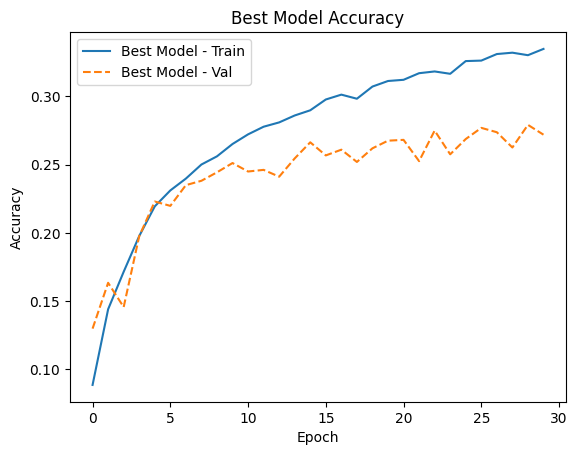

In [19]:
plt.plot(best_history['accuracy'], label=f'Best Model - Train')
plt.plot(best_history['val_accuracy'], linestyle='dashed', label=f'Best Model - Val')

plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

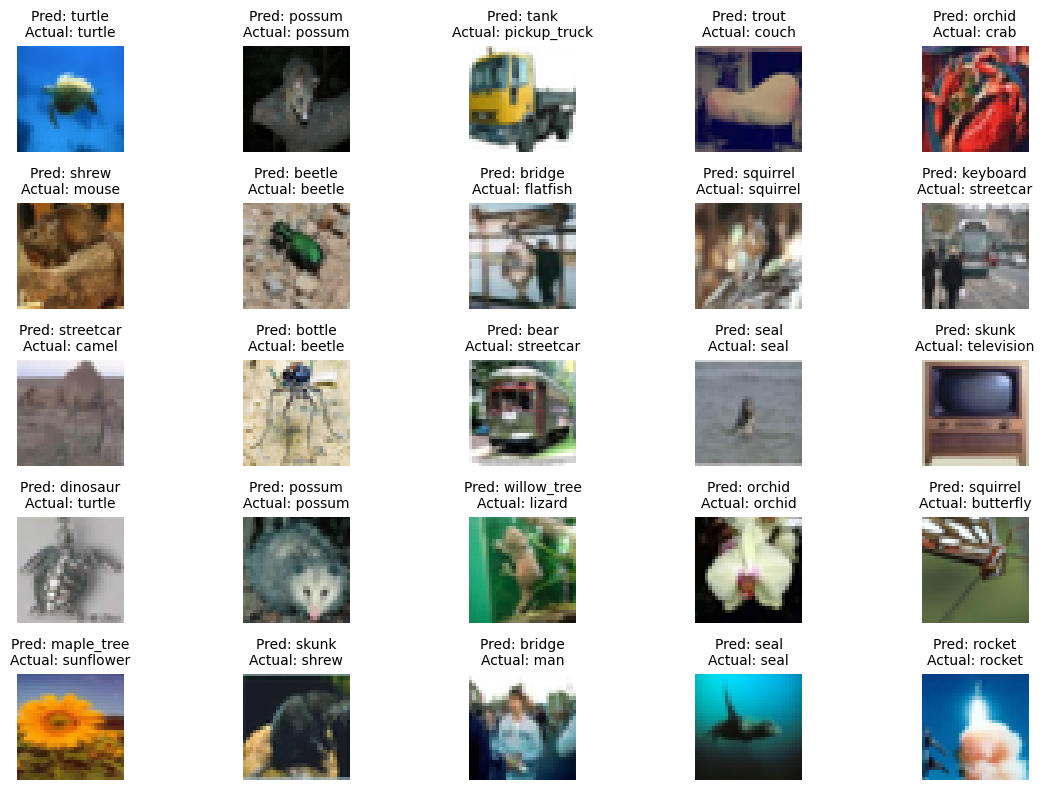

In [20]:
import numpy as np
import random
import matplotlib.pyplot as plt

# test 25 random images
random_indices = random.sample(range(len(x_test)), 25)
images = []
predicted_labels = []
expected_labels = []

for i, idx in enumerate(random_indices):
    test_image = x_test[idx]
    images.append(test_image)
    test_label = y_test[idx]

    test_images = np.expand_dims(test_image, axis=0)

    # get predicted class label
    predicted_index = np.argmax(best_model.predict(test_images, verbose=0))
    predicted_labels.append(class_labels[index_to_class_mapping[predicted_index]])

    # get expected label
    expected_index = np.argmax(test_label)
    expected_labels.append(class_labels[index_to_class_mapping[expected_index]])

plt.figure(figsize=(12, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Pred: {predicted_labels[i]}\nActual: {expected_labels[i]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Autoencoder
Building on your best performing model to this point, construct an autoencoder model to attempt
to reproduce input images. Discuss the appropriate use of loss functions and metrics for
evaluation.
Save the model notebook for the demo notebook and use later.

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape

def build_autoencoder(input_shape=(32, 32, 3), latent_neurons=32):
    # encoder using best model from previous question
    encoder_input = Input(shape=input_shape, name="encoder")
    x = Flatten()(encoder_input)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    latent_space = Dense(latent_neurons, activation='relu', name="latent")(x)

    encoder = Model(encoder_input, latent_space, name="encoder")

    # decoder (reverse of best model)
    decoder_input = Input(shape=(latent_neurons,), name="decoder")
    x = Dense(64, activation='relu')(decoder_input)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(np.prod(input_shape), activation='sigmoid')(x)  # Output size matches flattened input
    decoder_output = Reshape(input_shape)(x)

    decoder = Model(decoder_input, decoder_output, name="decoder")

    # auto encoder
    autoencoder_input = Input(shape=input_shape, name="autoencoder")
    encoded = encoder(autoencoder_input)
    reconstructed = decoder(encoded)
    autoencoder = Model(autoencoder_input, reconstructed, name="autoencoder")

    return autoencoder, encoder, decoder

In [37]:
# Initial autoencoding didn't look great. Trying different dimension sizes for latent layer
best_accuracy = 0
best_dim =0
best_autoencoder = None
best_encoder = None
best_decoder = None

for latent_neurons in [16, 32, 64, 128]:
    print(f"Auto encoder with latent neurons: {latent_neurons}")
    autoencoder, encoder, decoder = build_autoencoder(input_shape=(32, 32, 3), latent_neurons=latent_neurons)

    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    history = autoencoder.fit(
        x_train, x_train,
        validation_data=(x_test, x_test),
        epochs=30,
        batch_size=64,
        verbose=1
    )

    loss, accuracy = autoencoder.evaluate(x_test, x_test, verbose=0)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dim = latent_neurons
        best_autoencoder = autoencoder
        best_encoder = encoder
        best_decoder = decoder

    print(f"Latent Neurons: {latent_neurons} Accuracy: {accuracy:.4f} Loss: {loss:.4f}")

Auto encoder with latent neurons: 16
Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.4679 - loss: 0.0568 - val_accuracy: 0.5399 - val_loss: 0.0361
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5640 - loss: 0.0347 - val_accuracy: 0.6142 - val_loss: 0.0320
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6164 - loss: 0.0315 - val_accuracy: 0.6218 - val_loss: 0.0317
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6181 - loss: 0.0312 - val_accuracy: 0.6136 - val_loss: 0.0316
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6194 - loss: 0.0310 - val_accuracy: 0.6084 - val_loss: 0.0316
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6166 - loss: 0.0307 - val_accuracy: 0.6020 - val_loss: 0.0296
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6143 - loss: 0.0288 - val_accuracy: 0.6137 - val_loss: 0.0289
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0

In [38]:
print("Best latent layer dimension (neurons): ",best_dim)
print("Accuracy: ",best_accuracy)

Best latent layer dimension (neurons):  32
Accuracy:  0.6770103573799133


In [24]:
# best_autoencoder, best_encoder, best_decoder = build_autoencoder(input_shape=(32, 32, 3), latent_neurons=32) # rerun this line to save time

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


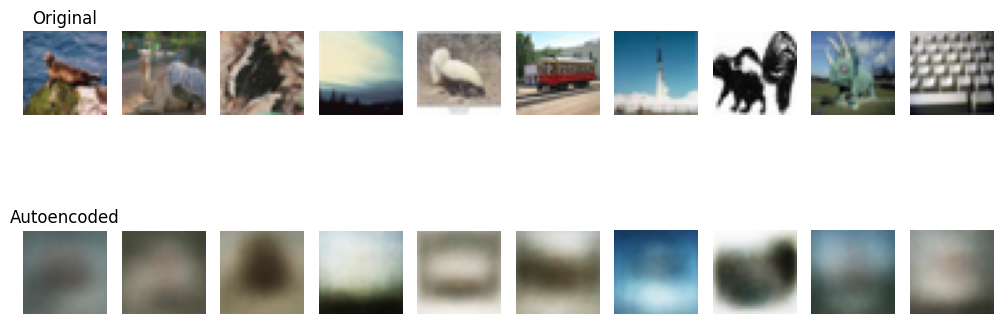

In [39]:
import matplotlib.pyplot as plt

# reconstruct 10 test images
reconstructed_images = best_autoencoder.predict(x_test[:10])

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i])
    plt.axis('off')
    if i == 0:
        plt.title("Original")

    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed_images[i])
    plt.axis('off')
    if i == 0:
        plt.title("Autoencoded")

plt.tight_layout()
plt.show()

# Export for demo

In [40]:
# pickle demo data, models etc.
from google.colab import files

to_save = {
    #"x_test": x_test,
    "y_test": y_test,
    "best_model": best_model,
    "best_history": best_history,
    "best_autoencoder": best_autoencoder,
    "index_to_class_mapping": index_to_class_mapping,
    "class_labels": class_labels
}

with open('image_processing.pkl', 'wb') as f:
    pickle.dump(to_save, f)

to_save = {
    "x_test": x_test,
    #"y_test": y_test,
    #"best_model": model,
    #"best_autoencoder": best_autoencoder,
    #"index_to_class_mapping": index_to_class_mapping,
    #"class_labels": class_labels
}

with open('image_processing_x_test.pkl', 'wb') as f:
    pickle.dump(to_save, f)

# Download the file
files.download("image_processing.pkl")
files.download("image_processing_x_test.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>